
<div style="text-align: center;">
    <strong style="display: block; margin-bottom: 10px;">Group AU</strong> 
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Joana Rodrigues</td>
            <td style="border: 1px solid white; padding: 8px;">20240603</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Mara Simões</td>
            <td style="border: 1px solid white; padding: 8px;">20240326</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Matilde Street</td>
            <td style="border: 1px solid white; padding: 8px;">20240523</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Rafael Silva</td>
            <td style="border: 1px solid white; padding: 8px;">20240511</td>
        </tr>
    </table>
</div>

### 🔗 Table of Contents <a id='table-of-contents'></a>
1. [Imports](#imports)
---

# 1. Imports
## 1.1. Import libraries

In [11]:
from pathlib import Path
import pandas as pd
#from google.colab import drive
import numpy as np
import random
from copy import deepcopy
from typing import Callable
import math

## 1.2. Import dataset

In [34]:
path = 'seating_data.xlsx'
df = pd.read_excel(path)
df= df.set_index('idx')

print(df.head())


#drive.mount('/content/drive')
#df = pd.read_csv("seating_data(in).csv", index_col=0)

       1     2     3     4    5    6    7    8    9    10  ...   55   56  57  \
idx                                                        ...                 
1       0  5000     0     0  700  700    0    0    0    0  ...  100  100   0   
2    5000     0   700   700    0    0  300  300  500  500  ...  100  100   0   
3       0   700     0  2000    0    0    0    0  300  300  ...    0    0   0   
4       0   700  2000     0    0    0  900  400  300  300  ...    0    0   0   
5     700     0     0     0    0    0    0    0    0    0  ...    0    0   0   

      58   59   60   61  62  63  64  
idx                                  
1      0  100  100  100   0   0   0  
2    100    0    0    0   0   0   0  
3      0    0    0    0   0   0   0  
4      0    0    0    0   0   0   0  
5      0    0    0    0   0   0   0  

[5 rows x 64 columns]


In [35]:
is_symmetric = (df == df.T).all().all()
print("Matrix is simetric?", is_symmetric)


Matrix is simetric? False


In [39]:
asymmetric_pairs = []
for i in df.index:
    for j in df.columns:
        if i != j and df.loc[i, j] != df.loc[j, i]:
            asymmetric_pairs.append((i, j, df.loc[i, j], df.loc[j, i]))

for a, b, val1, val2 in asymmetric_pairs:
    print(f"({a}, {b}) = {val1}")


(1, 54) = 1000
(2, 54) = 100
(54, 1) = 0
(54, 2) = 1000


It's said that 54 is the bride's best friend and not the groom's so we correct this mistake so that the matrix is simetric

In [ ]:
df.at[1, 54] = df.at[54, 1] = 0
df.at[2, 54] = df.at[54, 2] = 1000

In [40]:
# 64 people in 8 tables with 8 seats each

total_combinations = math.factorial(64) // ((math.factorial(8) ** 8) * math.factorial(8))
print('The people invited to the wedding can be sat in ', total_combinations, 'different ways, as there are 8 tables each with 8 seats.')

The people invited to the wedding can be sat in  450538787986875167583433232345723106006796340625 different ways, as there are 8 tables each with 8 seats.


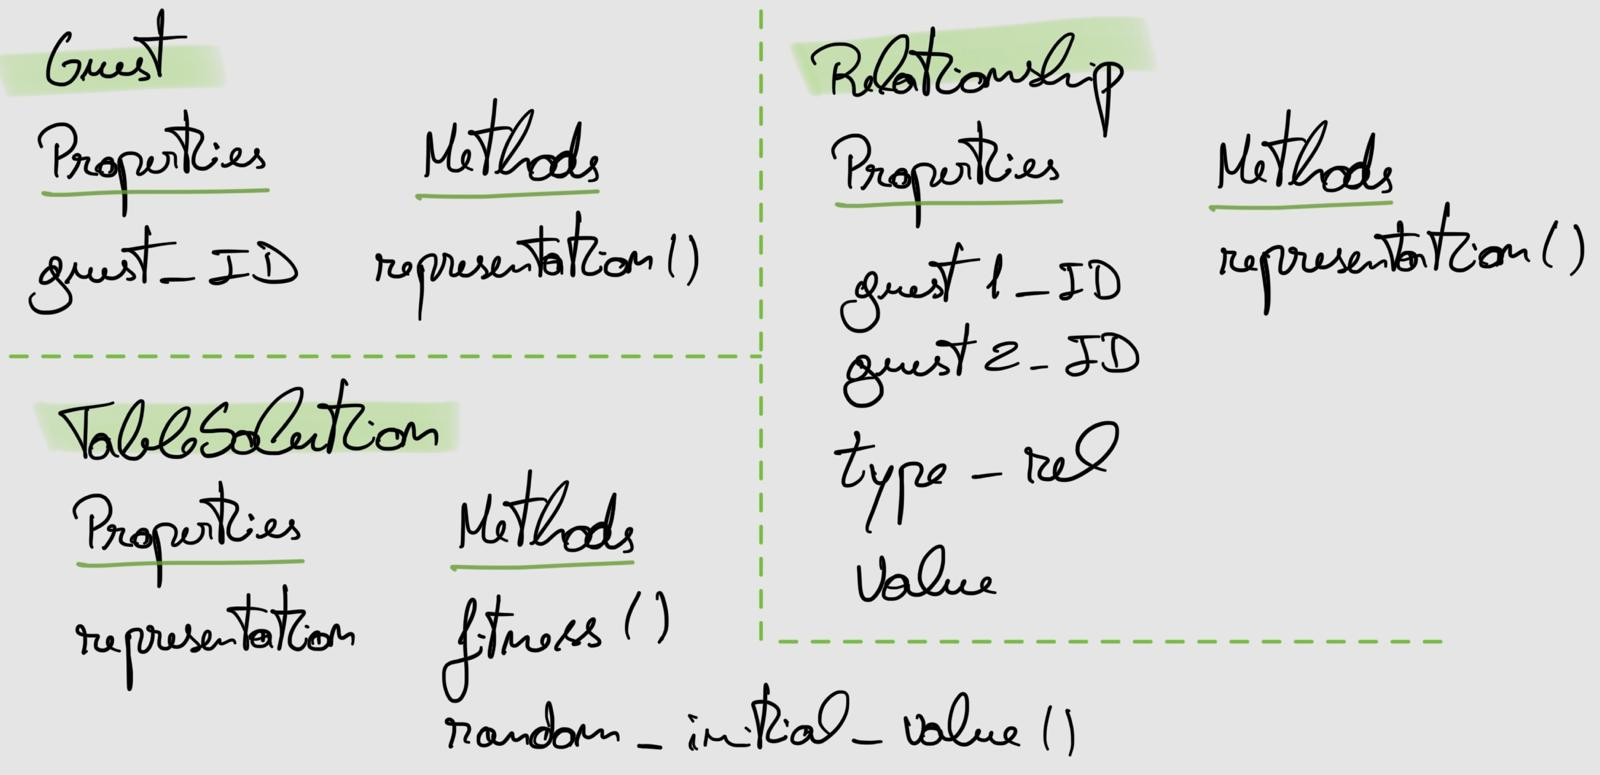

experimento de fitness sharing

In [ ]:
### --- CLASSE GUEST ---
class Guest:
    def __init__(self, guest_id):
        self.guest_id = guest_id

    def __repr__(self):
        return f"{self.guest_id}"

### --- LER MATRIZ DE RELAÇÕES ---
relationship_matrix = df.to_numpy()
guest_ids = list(df.index)
guests = [Guest(guest_id) for guest_id in guest_ids]
def similarity(ind1, ind2):
    """Conta o número de convidados sentados nas mesmas mesas (simples métrica de semelhança)."""
    count = 0
    for t1, t2 in zip(ind1.representation, ind2.representation):
        ids1 = set(g.guest_id for g in t1)
        ids2 = set(g.guest_id for g in t2)
        count += len(ids1 & ids2)  # interseção
    return count


class TableSolution:
    def __init__(self, num_tables=8, guests_per_table=8, guests=None, initialization_type='random'):
        self.num_tables = num_tables
        self.guests_per_table = guests_per_table
        self.representation = [[] for _ in range(num_tables)]

        if guests:
            if initialization_type == 'random':
                self.random_initial_value(guests)
            elif initialization_type == 'sequential':
                self.sequential_initial_value(guests)
            else:
                raise ValueError("Initialization type must be 'random' or 'sequential'")

    def random_initial_value(self, guests):
        shuffled = deepcopy(guests)
        random.shuffle(shuffled)
        for i, guest in enumerate(shuffled):
            self.representation[i % self.num_tables].append(guest)

    def sequential_initial_value(self, guests):
        for i, guest in enumerate(guests):
            table_idx = i // self.guests_per_table 
            self.representation[table_idx].append(guest)

    def fitness(self):
        score = 0
        for table in self.representation:
            for i in range(len(table)):
                for j in range(i + 1, len(table)):
                    g1 = guest_ids.index(table[i].guest_id)
                    g2 = guest_ids.index(table[j].guest_id)
                    score += relationship_matrix[g1][g2]
        return score

    def crossover(self, other):
        cut = random.randint(1, self.num_tables - 2)
        child1_tables = self.representation[:cut] + other.representation[cut:]
        child2_tables = other.representation[:cut] + self.representation[cut:]

        child1 = TableSolution()
        child2 = TableSolution()

        child1.representation = self.repair(child1_tables)
        child2.representation = self.repair(child2_tables)

        return child1, child2

    def mutation(self, prob):
        new_solution = deepcopy(self)
        for _ in range(self.num_tables):
            if random.random() < prob:
                t1, t2 = random.sample(range(self.num_tables), 2)
                if new_solution.representation[t1] and new_solution.representation[t2]:
                    g1 = random.choice(new_solution.representation[t1])
                    g2 = random.choice(new_solution.representation[t2])
                    i1 = new_solution.representation[t1].index(g1)
                    i2 = new_solution.representation[t2].index(g2)
                    new_solution.representation[t1][i1], new_solution.representation[t2][i2] = g2, g1
        return new_solution

    def repair(self, tables):
        # Garante que cada convidado aparece apenas uma vez
        flat = [g for table in tables for g in table]
        counts = {}
        for g in flat:
            counts[g.guest_id] = counts.get(g.guest_id, 0) + 1

        unique_guests = []
        seen = set()
        for g in flat:
            if g.guest_id not in seen:
                unique_guests.append(g)
                seen.add(g.guest_id)

        while len(unique_guests) < len(guests):
            for g in guests:
                if g.guest_id not in seen:
                    unique_guests.append(g)
                    seen.add(g.guest_id)

        repaired = [[] for _ in range(self.num_tables)]
        for i, g in enumerate(unique_guests):
            repaired[i % self.num_tables].append(g)
        return repaired

    def __repr__(self):
        return f"Solution (fitness={self.fitness()}): {self.representation}"


### --- FUNÇÕES GA (usadas em aula) ---
def get_best_ind(population: list, maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]


def fitness_proportionate_selection(population: list, maximization: bool, fitness_sharing: bool = False):
    if fitness_sharing:
        shared_fitness_values = []
        for i, ind_i in enumerate(population):
            raw_fitness = ind_i.fitness()
            sharing_sum = 0
            for j, ind_j in enumerate(population):
                if i != j:
                    sim = similarity(ind_i, ind_j)
                    sharing_sum += 1 / (1 + sim)
            adjusted_fitness = raw_fitness / (1 + sharing_sum)
            shared_fitness_values.append(adjusted_fitness)
        fitness_values = shared_fitness_values
    else:
        fitness_values = [ind.fitness() for ind in population]

    if not maximization:
        fitness_values = [1 / (f + 1e-6) for f in fitness_values]  # evita divisão por zero

    total_fitness = sum(fitness_values)
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0

    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

def genetic_algorithm(
    initial_population: list,
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
):
    population = initial_population

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'--- Generation {gen} ---')

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first = selection_algorithm(population, maximization)
            second = selection_algorithm(population, maximization)

            if random.random() < xo_prob:
                o1, o2 = first.crossover(second)
            else:
                o1, o2 = deepcopy(first), deepcopy(second)

            new_population.append(o1.mutation(mut_prob))
            if len(new_population) < len(population):
                new_population.append(o2.mutation(mut_prob))

        population = new_population

        if verbose:
            best = get_best_ind(population, maximization)
            print(f"Best fitness in generation {gen}: {best.fitness()}")

    return get_best_ind(population, maximization)


### --- EXECUTAR O GA ---
initial_population = [TableSolution(guests=guests, initialization_type='sequential') for _ in range(100)]


selection_algo = lambda pop, max_: fitness_proportionate_selection(
    pop, max_, fitness_sharing=True)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=selection_algo,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True)

print("\nBest solution found:")
print(best_solution)

# we can modify in: 
# initial_population: initialization_type = 'random' or 'sequential'
# selection_algo: fitness_sharing = True
# best_solution: ...


--- Generation 1 ---
Best fitness in generation 1: 56300
--- Generation 2 ---
Best fitness in generation 2: 56300
--- Generation 3 ---
Best fitness in generation 3: 56300
--- Generation 4 ---
Best fitness in generation 4: 56300
--- Generation 5 ---
Best fitness in generation 5: 56300
--- Generation 6 ---
Best fitness in generation 6: 56300
--- Generation 7 ---
Best fitness in generation 7: 56300
--- Generation 8 ---
Best fitness in generation 8: 56300
--- Generation 9 ---
Best fitness in generation 9: 56300
--- Generation 10 ---
Best fitness in generation 10: 56300
--- Generation 11 ---
Best fitness in generation 11: 56300
--- Generation 12 ---
Best fitness in generation 12: 56300
--- Generation 13 ---
Best fitness in generation 13: 56300
--- Generation 14 ---
Best fitness in generation 14: 56300
--- Generation 15 ---
Best fitness in generation 15: 56300
--- Generation 16 ---
Best fitness in generation 16: 56300
--- Generation 17 ---
Best fitness in generation 17: 56300
--- Generation 

Sem a cena do fitness_sharing
É igual a meter fitness_sharing= False mas se p algum motivo quisermos usar sem, está aqui

In [ ]:
### --- CLASSE GUEST ---
class Guest:
    def __init__(self, guest_id):
        self.guest_id = guest_id

    def __repr__(self):
        return f"{self.guest_id}"

### --- LER MATRIZ DE RELAÇÕES ---
relationship_matrix = df.to_numpy()
guest_ids = list(df.index)
guests = [Guest(guest_id) for guest_id in guest_ids]

class TableSolution:
    def __init__(self, num_tables=8, guests_per_table=8, guests=None, initialization_type='random'):
        self.num_tables = num_tables
        self.guests_per_table = guests_per_table
        self.representation = [[] for _ in range(num_tables)]

        if guests:
            # Seleciona o tipo de inicialização com base no argumento
            if initialization_type == 'random':
                self.random_initial_value(guests)
            elif initialization_type == 'sequential':
                self.sequential_initial_value(guests)
            else:
                raise ValueError("Initialization type must be 'random' or 'sequential'")

    def random_initial_value(self, guests):
        shuffled = deepcopy(guests)
        random.shuffle(shuffled)
        for i, guest in enumerate(shuffled):
            self.representation[i % self.num_tables].append(guest)

    def sequential_initial_value(self, guests):
        for i, guest in enumerate(guests):
            table_idx = i // self.guests_per_table 
            self.representation[table_idx].append(guest)

    def fitness(self):
        score = 0
        for table in self.representation:
            for i in range(len(table)):
                for j in range(i + 1, len(table)):
                    g1 = guest_ids.index(table[i].guest_id)
                    g2 = guest_ids.index(table[j].guest_id)
                    score += relationship_matrix[g1][g2]
        return score

    def crossover(self, other):
        cut = random.randint(1, self.num_tables - 2)
        child1_tables = self.representation[:cut] + other.representation[cut:]
        child2_tables = other.representation[:cut] + self.representation[cut:]

        child1 = TableSolution()
        child2 = TableSolution()

        child1.representation = self.repair(child1_tables)
        child2.representation = self.repair(child2_tables)

        return child1, child2

    def mutation(self, prob):
        new_solution = deepcopy(self)
        for _ in range(self.num_tables):
            if random.random() < prob:
                t1, t2 = random.sample(range(self.num_tables), 2)
                if new_solution.representation[t1] and new_solution.representation[t2]:
                    g1 = random.choice(new_solution.representation[t1])
                    g2 = random.choice(new_solution.representation[t2])
                    i1 = new_solution.representation[t1].index(g1)
                    i2 = new_solution.representation[t2].index(g2)
                    new_solution.representation[t1][i1], new_solution.representation[t2][i2] = g2, g1
        return new_solution

    def repair(self, tables):
        # Garante que cada convidado aparece apenas uma vez
        flat = [g for table in tables for g in table]
        counts = {}
        for g in flat:
            counts[g.guest_id] = counts.get(g.guest_id, 0) + 1

        unique_guests = []
        seen = set()
        for g in flat:
            if g.guest_id not in seen:
                unique_guests.append(g)
                seen.add(g.guest_id)

        while len(unique_guests) < len(guests):
            for g in guests:
                if g.guest_id not in seen:
                    unique_guests.append(g)
                    seen.add(g.guest_id)

        repaired = [[] for _ in range(self.num_tables)]
        for i, g in enumerate(unique_guests):
            repaired[i % self.num_tables].append(g)
        return repaired

    def __repr__(self):
        return f"Solution (fitness={self.fitness()}): {self.representation}"


### --- FUNÇÕES GA (usadas em aula) ---
def get_best_ind(population: list, maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]


def fitness_proportionate_selection(population: list, maximization: bool):
    if maximization:
        fitness_values = [ind.fitness() for ind in population]
    else:
        fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0

    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)


def genetic_algorithm(
    initial_population: list,
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
):
    population = initial_population

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'--- Generation {gen} ---')

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first = selection_algorithm(population, maximization)
            second = selection_algorithm(population, maximization)

            if random.random() < xo_prob:
                o1, o2 = first.crossover(second)
            else:
                o1, o2 = deepcopy(first), deepcopy(second)

            new_population.append(o1.mutation(mut_prob))
            if len(new_population) < len(population):
                new_population.append(o2.mutation(mut_prob))

        population = new_population

        if verbose:
            best = get_best_ind(population, maximization)
            print(f"Best fitness in generation {gen}: {best.fitness()}")

    return get_best_ind(population, maximization)


### --- EXECUTAR O GA ---
initial_population = [TableSolution(guests=guests, initialization_type='random') for _ in range(100)]

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=fitness_proportionate_selection,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True
)

print("\nBest solution found:")
print(best_solution)


--- Generation 1 ---
Best fitness in generation 1: 22200
--- Generation 2 ---
Best fitness in generation 2: 24600
--- Generation 3 ---
Best fitness in generation 3: 24600
--- Generation 4 ---
Best fitness in generation 4: 24600
--- Generation 5 ---
Best fitness in generation 5: 25500
--- Generation 6 ---
Best fitness in generation 6: 27500
--- Generation 7 ---
Best fitness in generation 7: 27500
--- Generation 8 ---
Best fitness in generation 8: 27500
--- Generation 9 ---
Best fitness in generation 9: 27500
--- Generation 10 ---
Best fitness in generation 10: 27500
--- Generation 11 ---
Best fitness in generation 11: 27500
--- Generation 12 ---
Best fitness in generation 12: 27500
--- Generation 13 ---
Best fitness in generation 13: 27500
--- Generation 14 ---
Best fitness in generation 14: 27500
--- Generation 15 ---
Best fitness in generation 15: 27500
--- Generation 16 ---
Best fitness in generation 16: 27500
--- Generation 17 ---
Best fitness in generation 17: 27500
--- Generation 

In [ ]:
### --- CLASSE GUEST ---
class Guest:
    def __init__(self, guest_id):
        self.guest_id = guest_id

    def __repr__(self):
        return f"{self.guest_id}"

### --- LER MATRIZ DE RELAÇÕES ---
relationship_matrix = df.to_numpy()
guest_ids = list(df.index)
guests = [Guest(guest_id) for guest_id in guest_ids]
def similarity(ind1, ind2):
    """Conta o número de convidados sentados nas mesmas mesas (simples métrica de semelhança)."""
    count = 0
    for t1, t2 in zip(ind1.representation, ind2.representation):
        ids1 = set(g.guest_id for g in t1)
        ids2 = set(g.guest_id for g in t2)
        count += len(ids1 & ids2)  
    return count


class TableSolution:
    def __init__(self, num_tables=8, guests_per_table=8, guests=None, initialization_type='random'):
        self.num_tables = num_tables
        self.guests_per_table = guests_per_table
        self.representation = [[] for _ in range(num_tables)]

        if guests:
            if initialization_type == 'random':
                self.random_initial_value(guests)
            elif initialization_type == 'sequential':
                self.sequential_initial_value(guests)
            else:
                raise ValueError("Initialization type must be 'random' or 'sequential'")

    def random_initial_value(self, guests):
        shuffled = deepcopy(guests)
        random.shuffle(shuffled)
        for i, guest in enumerate(shuffled):
            self.representation[i % self.num_tables].append(guest)

    def sequential_initial_value(self, guests):
        for i, guest in enumerate(guests):
            table_idx = i // self.guests_per_table 
            self.representation[table_idx].append(guest)

    def fitness(self):
        score = 0
        for table in self.representation:
            for i in range(len(table)):
                for j in range(i + 1, len(table)):
                    g1 = guest_ids.index(table[i].guest_id)
                    g2 = guest_ids.index(table[j].guest_id)
                    score += relationship_matrix[g1][g2]
        return score

    def crossover(self, other):
        cut = random.randint(1, self.num_tables - 2)
        child1_tables = self.representation[:cut] + other.representation[cut:]
        child2_tables = other.representation[:cut] + self.representation[cut:]

        child1 = TableSolution()
        child2 = TableSolution()

        child1.representation = self.repair(child1_tables)
        child2.representation = self.repair(child2_tables)

        return child1, child2

    def mutation(self, prob):
        new_solution = deepcopy(self)
        for _ in range(self.num_tables):
            if random.random() < prob:
                t1, t2 = random.sample(range(self.num_tables), 2)
                if new_solution.representation[t1] and new_solution.representation[t2]:
                    g1 = random.choice(new_solution.representation[t1])
                    g2 = random.choice(new_solution.representation[t2])
                    i1 = new_solution.representation[t1].index(g1)
                    i2 = new_solution.representation[t2].index(g2)
                    new_solution.representation[t1][i1], new_solution.representation[t2][i2] = g2, g1
        return new_solution

    def repair(self, tables):
        # Garante que cada convidado aparece apenas uma vez
        flat = [g for table in tables for g in table]
        counts = {}
        for g in flat:
            counts[g.guest_id] = counts.get(g.guest_id, 0) + 1

        unique_guests = []
        seen = set()
        for g in flat:
            if g.guest_id not in seen:
                unique_guests.append(g)
                seen.add(g.guest_id)

        while len(unique_guests) < len(guests):
            for g in guests:
                if g.guest_id not in seen:
                    unique_guests.append(g)
                    seen.add(g.guest_id)

        repaired = [[] for _ in range(self.num_tables)]
        for i, g in enumerate(unique_guests):
            repaired[i % self.num_tables].append(g)
        return repaired

    def __repr__(self):
        return f"Solution (fitness={self.fitness()}): {self.representation}"


### --- FUNÇÕES GA (usadas em aula) ---
def get_best_ind(population: list, maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]


def fitness_proportionate_selection(population: list, maximization: bool, fitness_sharing: bool = False):
    if fitness_sharing:
        shared_fitness_values = []
        for i, ind_i in enumerate(population):
            raw_fitness = ind_i.fitness()
            sharing_sum = 0
            for j, ind_j in enumerate(population):
                if i != j:
                    sim = similarity(ind_i, ind_j)
                    sharing_sum += 1 / (1 + sim)
            adjusted_fitness = raw_fitness / (1 + sharing_sum)
            shared_fitness_values.append(adjusted_fitness)
        fitness_values = shared_fitness_values
    else:
        fitness_values = [ind.fitness() for ind in population]

    if not maximization:
        fitness_values = [1 / (f + 1e-6) for f in fitness_values] 

    total_fitness = sum(fitness_values)
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0

    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

def genetic_algorithm(
    initial_population: list,
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
):
    population = initial_population

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'--- Generation {gen} ---')

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first = selection_algorithm(population, maximization)
            second = selection_algorithm(population, maximization)

            if random.random() < xo_prob:
                o1, o2 = first.crossover(second)
            else:
                o1, o2 = deepcopy(first), deepcopy(second)

            new_population.append(o1.mutation(mut_prob))
            if len(new_population) < len(population):
                new_population.append(o2.mutation(mut_prob))

        population = new_population

        if verbose:
            best = get_best_ind(population, maximization)
            print(f"Best fitness in generation {gen}: {best.fitness()}")

    return get_best_ind(population, maximization)


### --- EXECUTAR O GA ---
initial_population = [TableSolution(guests=guests, initialization_type='sequential') for _ in range(100)]


selection_algo = lambda pop, max_: fitness_proportionate_selection(
    pop, max_, fitness_sharing=False)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=200,
    selection_algorithm=selection_algo,
    maximization=True,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=True)

print("\nBest solution found:")
print(best_solution)


--- Generation 1 ---
Best fitness in generation 1: 59300
--- Generation 2 ---
Best fitness in generation 2: 59300
--- Generation 3 ---
Best fitness in generation 3: 59300
--- Generation 4 ---
Best fitness in generation 4: 59300
--- Generation 5 ---
Best fitness in generation 5: 59300
--- Generation 6 ---
Best fitness in generation 6: 59300
--- Generation 7 ---
Best fitness in generation 7: 60200
--- Generation 8 ---
Best fitness in generation 8: 60200
--- Generation 9 ---
Best fitness in generation 9: 60200
--- Generation 10 ---
Best fitness in generation 10: 60200
--- Generation 11 ---
Best fitness in generation 11: 60200
--- Generation 12 ---
Best fitness in generation 12: 60200
--- Generation 13 ---
Best fitness in generation 13: 60200
--- Generation 14 ---
Best fitness in generation 14: 60200
--- Generation 15 ---
Best fitness in generation 15: 60200
--- Generation 16 ---
Best fitness in generation 16: 60200
--- Generation 17 ---
Best fitness in generation 17: 60200
--- Generation 

Grid-search aos parametros da função

In [19]:
#diria pa so se fzr qd ja tivermos td ou quase td oq quisermos implementar na funçao mas terá de ser feito
# aspetos a explorar:
# -mutation
# -crossover
# -max_gen
# -...

Visualization     
For visualization purposes, we create a dataframe with the numbers of people to understand who is sat together

In [ ]:
df_people = [(1, "groom", "groom"),
    (2, "bride", "bride"),
    (3, "bride", "father"),
    (4, "bride", "mother"),
    (5, "groom", "father"),
    (6, "groom", "mother"),
    (7, "groom", "aunt"),
    (8, "groom", "uncle"),
    (9, "groom", "cousin"),
    (10, "groom", "cousin"),
    (11, "bride", "uncle"),
    (12, "bride", "aunt"),
    (13, "groom", "uncle"),
    (14, "groom", "aunt"),
    (15, "groom", "cousin"),
    (16, "groom", "brother"),
    (17, "groom", "brother"),
    (18, "groom", "brother"),
    (19, "groom", "nephew"),
    (20, "groom", "sister_in_law"),
    (21, "groom", "niece2"),
    (22, "groom", "sister_in_law"),
    (23, "groom", "cousin"),
    (24, "groom", "uncle"),
    (25, "groom", "aunt"),
    (26, "groom", "uncle"),
    (27, "groom", "aunt"),
    (28, "groom", "cousin"),

    (29, "bride", "friend_college"),
    (30, "bride", "friend_college"),
    (31, "bride", "friend_college_son"),
    (32, "bride", "friend_college"),
    (33, "bride", "friend_college_date"),
    (34, "bride", "friend_college"),
    (35, "bride", "friend_college"),
    (36, "bride", "friend_college"),

    (37, "groom", "friend_college"),
    (38, "groom", "best_friend_college"),
    (44, "groom", "friend_college"),
    (50, "groom", "best_friend_college"),
    (60, "groom", "friend_college"),

    (39, "bride", "friend_hometown"),
    (40, "bride", "friend_hometown"),
    (41, "bride", "friend_hometown"),
    (42, "bride", "friend_hometown_son"),
    (43, "bride", "friend_hometown_son"),
    (45, "bride", "friend_hometown"),

    (51, "bride", "friend_work"),
    (52, "bride", "friend_work"),
    (53, "bride", "friend_work_son"),
    (54, "bride", "best_friend_work"),
    (55, "bride", "friend_work"),
    (56, "bride", "friend_work"),
    (57, "bride", "friend_work_date"),
    (58, "bride", "friend_work"),

    (59, "groom", "friend_work"),
    (61, "groom", "friend_work"),
    (62, "groom", "friend_work_date"),
    (63, "groom", "friend_work_son"),
    (64, "groom", "friend_work_son"),

    (46, "both", "friend_padel"),
    (47, "both", "friend_padel"),
    (48, "both", "friend_padel_date"),
    (49, "both", "friend_padel")]

df_people = pd.DataFrame(df_people, columns=["idx", "side", "relation"])
df_people = df_people.set_index('idx')


In [21]:
# Make sure df_people has 'index' as column

print('The previous code showed that the best combination of people siting is as follows:')
for i, table in enumerate(best_solution.representation, 1):
    print(f"\n🪑 Table {i}")
    for guest in table:
        guest_id = guest.guest_id
        if guest_id in df_people.index:
            side = df_people.loc[guest_id, 'side']
            relation = df_people.loc[guest_id, 'relation']
            
            print(f"- {guest_id}: {side} | {relation}")
        else:
            print(f"- {guest_id}: Not found in df_people")


The previous code showed that the best combination of people siting is as follows:

🪑 Table 1
- 1: groom | groom
- 2: bride | bride
- 3: bride | father
- 4: bride | mother
- 21: groom | niece2
- 6: groom | mother
- 7: groom | aunt
- 8: groom | uncle

🪑 Table 2
- 9: groom | cousin
- 10: groom | cousin
- 11: bride | uncle
- 12: bride | aunt
- 13: groom | uncle
- 14: groom | aunt
- 15: groom | cousin
- 16: groom | brother1

🪑 Table 3
- 17: groom | brother2
- 18: groom | brother3
- 19: groom | nephew2
- 20: groom | sister_in_law2
- 5: groom | father
- 22: groom | sister_in_law3
- 25: groom | aunt
- 24: groom | uncle

🪑 Table 4
- 23: groom | cousin
- 26: groom | uncle
- 27: groom | aunt
- 28: groom | cousin
- 29: bride | friend_college
- 30: bride | friend_college
- 31: bride | friend_college_son
- 39: bride | friend_hometown

🪑 Table 5
- 33: bride | friend_college_date
- 34: bride | friend_college
- 35: bride | friend_college
- 36: bride | friend_college
- 37: groom | friend_college
- 38: 

In [22]:
# NÃO É MUITO RELEVANTE THO

max_possible_fitness = np.triu(relationship_matrix, k=1).sum()
print("Fitness if everyone sat together:", int(max_possible_fitness))



Fitness if everyone sat together: 109900
